In [321]:
#import tensorflow as tf
#from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


# 1. Kernels
First we define functions that will be used to rerpersent the convolution kernel:

In [2]:
def f_Laguerre(t, order):
    """ Computes Laguerre polynomials at a given `order` at position `t`
    """
    if order == 1:
        return 1
    if order == 2:
        return -t+1
        
    Ln0 = 1
    Ln1 = -t+1
    n=2
    poly = []
    while n <= order+1:
        Ln = ((2*n+1-t)*Ln1-n*Ln0)/(n+1)
        Ln0=Ln1
        Ln1=Ln
        poly.append(Ln)
        n+=1
        
    return np.array(poly)

def f_Gauss_Hermite(t, order, beta = 1):
    """ Computes Laguerre polynomials at a given `order` at position `t`
    """
    
    t = t/beta
    if order == 1:
        return np.array([np.ones(len(t))*np.exp(-t**2/2)/(beta*2**order*(2*np.pi*np.math.factorial(order))**0.5)])
    if order == 2:
        return np.array([f_Gauss_Hermite(t, 1, beta = beta), 
                2*t*np.exp(-t**2/2)/(beta*2**order*(2*np.pi*np.math.factorial(order))**0.5)])
        
    
    Ln0 = np.ones(len(t))
    Ln1 = 2*t
    n=2
    poly = []
    while n <= order+1:
        Ln = 2*t*Ln1-2*n*Ln0
        Ln0=Ln1
        Ln1=Ln
        poly.append(Ln*np.exp(-t**2/2)/(beta*2**n*(2*np.pi*np.math.factorial(n))**0.5))
        n+=1
        
    return np.array(poly)

In [271]:
class Continuous():
    def __init__(self, ):
        pass
    
    def generator(self,):
        pass
    
    
class Laguerre(Continuous):
    def __init__(self, order):
        self.order = order
    
    def generator(self, t):
        return f_Laguerre(t, self.order)
    
    def __call__(self, t):
        return self.generator(t)
    
class Gauss_Hermite(Continuous):
    def __init__(self, order, beta):
        self.order = order
        self.beta = beta
    
    def generator(self, t):
        return f_Gauss_Hermite(t, self.order, self.beta)
    
    def __call__(self, t):
        return self.generator(t)
    
class GH_polynomial(Continuous):
    def __init__(self, weights, beta):
        self.weights = weights
        self.beta = beta
        self.order = len(weights)
    
    def generator(self, t):
        vectors = Gauss_Hermite(self.order, self.beta)(t)
        if not isinstance(self.weights, torch.Tensor):
            self.weights = torch.tensor(self.weights, dtype=torch.float)
        return torch.matmul(torch.tensor(vectors.T, dtype=torch.float), self.weights) 
    
    def __call__(self, t):
        return self.generator(t)
    

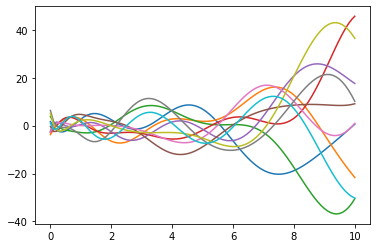

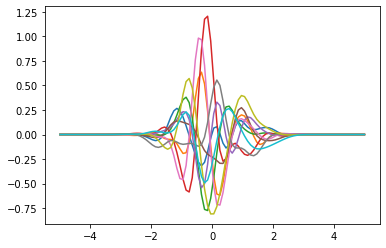

In [272]:

t = np.linspace(-5,5,100)
lags = Laguerre(20)(t+5)

hermits = Gauss_Hermite(20, beta=0.5)(t)

for j in range(10):
    weights = np.random.randn(20)
    plt.plot(t+5, np.dot(lags.T, weights))

plt.show()

for j in range(10):
    weights = np.random.randn(20)
    plt.plot(t, np.dot(hermits.T, weights))

plt.show()

# 2. Convolution operator
We need to define a convolution operation that takes an arbitrary number of unevenly spaced samples and outputs a vector of a specific length.

1.0
(1, 1, 100) (1, 1, 100)


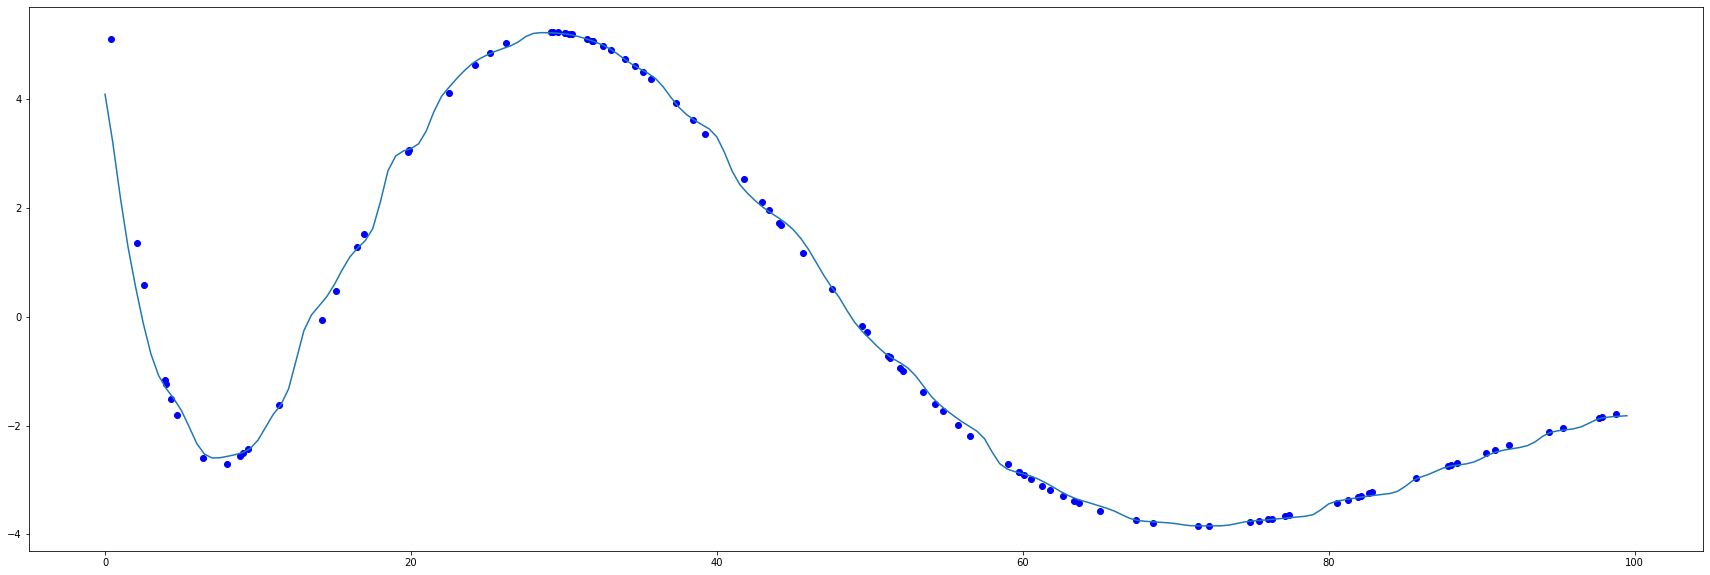

In [302]:
np.random.seed(10)
def continuous_conv(samples, times, kernel, kernel_length=None, length=None, offset=0):
    """
    Parrameters
    -----------
    samples: numpy.ndarray
        A vector that contains the measured samples to convolve sorted by measured time
    times: numpy.ndarray
        The sorted times at which samples were recorded. Should be tthe same length as `samples`.
    kernel: Continuous
        A Continuous class instance
    length: `float`
        Length (in time units) of the convolution kernel.
    length: `int`
        Length of the output vector.
    Returns
    -------
    convolved: numpy.ndarray
        A vector that contains the result of the convolution.
    """
    assert len(samples) == len(times)
    if length is None:
        span = np.max(np.array(times)) - np.min(np.array(times))
    t_start = np.min(np.array(times))#-kernel_length/2
    t_stop = np.max(np.array(times))#-kernel_length/2
    
    step_size = ((t_stop-t_start)/(length-1))
    norm = 1
    convolved = []
    track = []
    for i in range(length):
        
        loc = np.where(np.abs(times-(t_start+i*step_size))<kernel_length/2.)
        t_compute = times[loc]
        s_compute = samples[loc]
        
        loc_kernel = kernel(t_compute-(t_start+i*step_size))/norm + offset

        #plt.plot(t_compute-(t_start+i*step_size), loc_kernel.detach().numpy(), 'or')
        
        convolved.append((torch.sum(loc_kernel.t()*s_compute, axis = -1)
                         /torch.sum(loc_kernel.t(), axis = -1))[...,None])
        
    #plt.plot(np.linspace(-kernel_length/2, kernel_length/2, 100), 
    #             kernel(np.linspace(-kernel_length/2, kernel_length/2, 100))/norm)
    
    #plt.show()
    convolved = torch.cat(convolved, dim=-1)
    plt.figure(figsize=(30,10))
    plt.plot(times[0,0], samples[0,0], 'ob')
    for c in convolved:
        plt.plot(np.arange(length)/length*100, c.detach().numpy())
    plt.show()
    return convolved
    
t = np.sort(np.random.rand(100)*100)
gaps = t[1:]-t[:-1]
kernel_length = np.max(gaps)*2.

weights = np.random.randn(50)
lags = Laguerre(50)(t/100.)
s = np.dot(lags.T, weights)

beta = np.min([int(kernel_length)/5, 1])
print(beta)
kernel = GH_polynomial(np.random.randn(1,1), beta) 

length = 200
conv = continuous_conv(torch.tensor(s[None,None]), t[None,None], kernel, kernel_length=kernel_length, length=length)


In [296]:
class ContinuousLayer(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, shape_out, kernel, max_order, beta=None, bias = False):
        super().__init__()
        self.shape_out = shape_out
        self.kernel = kernel
        self.max_order = max_order
        self.beta = beta
        
        
        weights = torch.Tensor(max_order, self.shape_out[0])
        self.weights = nn.Parameter(weights)  # nn.Parameter is a Tensor that's a module parameter.
        if bias:
            bias = torch.Tensor(*shape_out)
            self.bias = nn.Parameter(bias)
        else: 
            self.bias = 0

        # initialize weights and biases
        nn.init.uniform_(self.weights, 1, 5) # weight init
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
        if bias:
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)  # bias init


    def forward(self, x):
        
        n_features = x.shape[-1]
        assert n_features//2 == n_features/2, "features should contain time samples and locations concatenated and should therefore be even-sized."
        
        times = np.array(x[...,n_features // 2:])
        max_gap = np.max(times[...,1:]-times[...,:-1])
        
        kernel_length = max_gap*1.1
        print(x.shape, times.shape)
        convolved = continuous_conv(x[...,:n_features // 2], 
                        times, 
                        self.kernel(self.weights, self.beta), 
                        kernel_length=kernel_length, 
                        length=self.shape_out[-1],
                        offset = 1)
        
        return torch.add(convolved, self.bias) 

In [313]:
class BasicModel(nn.Module):
    def __init__(self):
        super().__init__()
        #self.conv = nn.Conv2d(1, 128, 3)
        # self.linear = nn.Linear(256, 2)
        self.continuous = ContinuousLayer((3,200), 
                                      GH_polynomial, 
                                      10, 
                                      beta=1, 
                                      bias=False)#MyLinearLayer(256, 2)

    def forward(self, x):
        
        return self.continuous(x)
    
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.continuous = ContinuousLayer((3,200), 
                                     GH_polynomial, 
                                     10, 
                                     beta=1, 
                                     bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 160, kernel_size=(5,))
        self.fc1 = nn.Linear(16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.continuous(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

torch.Size([1, 1, 200]) (1, 1, 100)


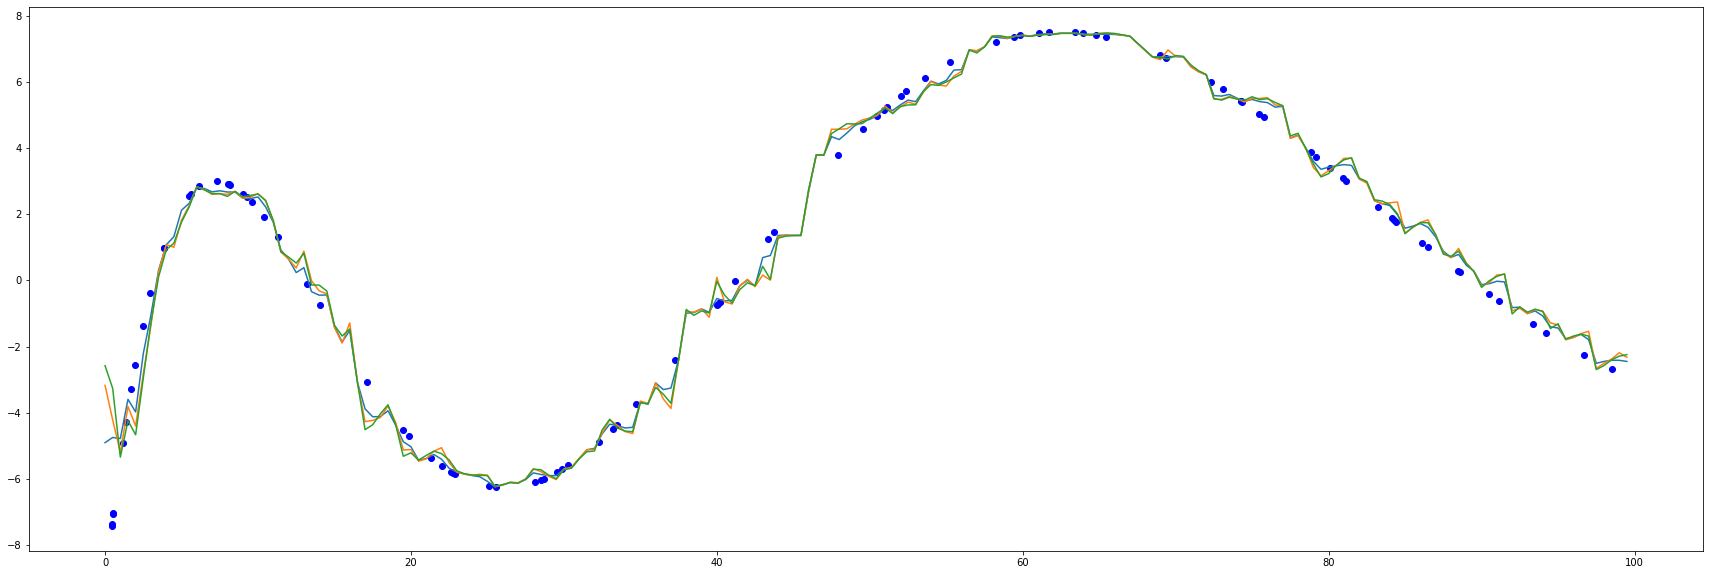

RuntimeError: non-empty 3D or 4D (batch mode) tensor expected for input

In [314]:
import math
#torch.manual_seed(0)  #  for repeatable results
basic_model = Net()

t = np.sort(np.random.rand(100)*100)
gaps = t[1:]-t[:-1]
kernel_length = np.max(gaps)*2.

weights = np.random.randn(50)
lags = Laguerre(50)(t/100.)
s = np.dot(lags.T, weights)

vector = np.concatenate([s, t])

inp = np.array([[vector]])
x = torch.tensor(inp, dtype=torch.float)
x2 = x[::4]
y1 = basic_model(x)
y2 = basic_model(x2)
print(y2.shape)

In [348]:
kernel_length = 5
#Create training set
t = np.sort(np.random.rand(100,2000)*100)

weights50 = np.random.randn(50,1000)
weights25 = np.random.randn(25,1000)
s50 = np.sum(Laguerre(50)(t[:,:1000]/100.) * weights50[:,None], axis = 0)
s25 = np.sum(Laguerre(25)(t[:,1000:]/100.) * weights25[:,None], axis = 0)
print(s25.shape, s50.shape)
s = np.concatenate([s25,s50], axis = 1)
print(s.shape)
vector = np.concatenate([s, t])

target = np.ones(2000)
target[:1000] *= 25
target[1000:] *= 50
    
print(vector.shape)

trn_ds = TensorDataset(
        torch.tensor(vector).float(), 
        torch.tensor(target).long())

trn_dl = DataLoader(trn_ds, batch_size=128, shuffle=True, num_workers=0)

(100, 1000) (100, 1000)
(100, 2000)
(200, 2000)


AssertionError: 

In [ ]:
print(vector.shape)